In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.cross_validation import cross_val_score,KFold
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler,LabelEncoder, OneHotEncoder
from scipy.stats import mode
import re
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



## workflow

1.Question or problem definition.
2.Acquire training and testing data.
3.Wrangle, prepare, cleanse the data.
4.Analyze, identify patterns, and explore the data.
5.Model, predict and solve the problem.
6.Visualize, report, and present the problem solving steps and final solution.

In [2]:
train=pd.read_csv("./data/train.csv")
test=pd.read_csv("./data/test.csv")
data_cleaner=[train,test]
print train.shape,test.shape

(891, 12) (418, 11)


# NA

In [3]:
print "Train NULL values: ", train.isnull().sum()
print "Test NULL values: ", test.isnull().sum()

Train NULL values:  PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Test NULL values:  PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
for d in data_cleaner:
    d['Age'].fillna(d["Age"].mean(),inplace=True)
    d['Fare'].fillna(d['Fare'].mean(),inplace=True)
    d['Cabin'].fillna("unknown",inplace=True)
    d['Embarked'].fillna(mode(d['Embarked'])[0][0],inplace=True)

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


## Graphs

In [5]:
"""
# age
plt.figure(figsize=(8,4))
sns.kdeplot(train_df.Age,shade=True)
plt.xlabel("age")
plt.show()
"""

'\n# age\nplt.figure(figsize=(8,4))\nsns.kdeplot(train_df.Age,shade=True)\nplt.xlabel("age")\nplt.show()\n'

## Features

In [6]:
for d in data_cleaner:
    d['name_length']=d['Name'].str.len()
    d['family_size']=d['SibSp'] + d['Parch'] + 1
    d['is_along']=(d["family_size"]==1)
    d['Has_Cabin'] = d["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    d["title"]=d['Name'].str.extract('[A-Za-z]+, ([^.]+)')
    d['title']=d['title'].replace(['Lady', 'the Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                   'Rev', 'Sir', 'Jonkheer', 'Dona', "Mme"],"Rare")
    d["title"]=d['title'].replace('Mlle',"Miss")
    d["title"]=d['title'].replace('Ms',"Miss")
    d["title"]=d['title'].replace('Mlle',"Miss")
    d['FareBin'] = pd.qcut(d['Fare'], 4)
    d['AgeBin'] = pd.cut(d['Age'].astype(int), 5)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [7]:
cols=['Sex','title','Embarked',"FareBin","AgeBin"]
for d in data_cleaner:
    d.drop(['PassengerId','Name','Ticket','Cabin',"Age","Fare"],axis=1,inplace=True)
    for col in cols:
        lbl=LabelEncoder()
        lbl.fit(d[col].unique())
        d[col]=lbl.transform(d[col])

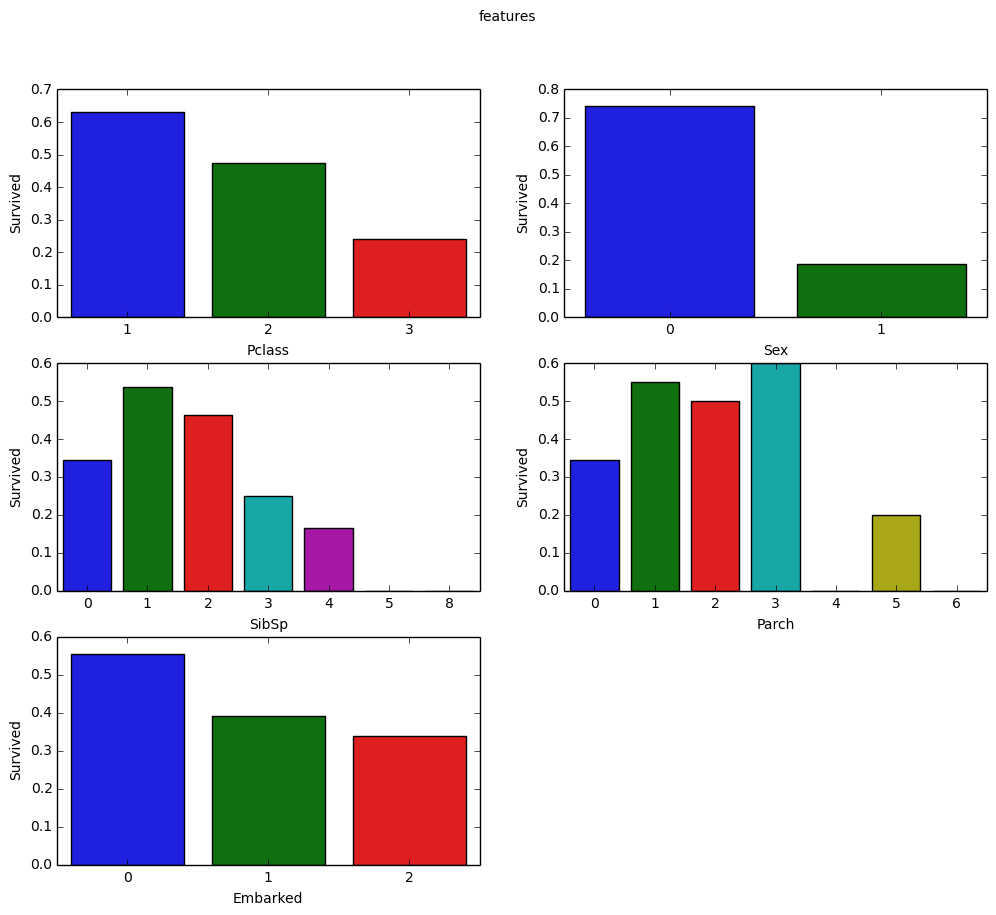

In [8]:
# pclass vs survived
plt.figure(figsize=(12,10))
plt.suptitle("features")
plt.subplot(321)
x = train[['Pclass','Survived']].groupby(['Pclass'],as_index=False).mean().sort_values(by="Survived",ascending=False)
sns.barplot(x.Pclass,x.Survived)
plt.subplot(322)
x = train[["Sex","Survived"]].groupby(["Sex"],as_index=False).mean().sort_values(by="Survived",ascending=False)
sns.barplot(x.Sex,x.Survived)
plt.subplot(323)
x = train[["SibSp","Survived"]].groupby(["SibSp"],as_index=False).mean().sort_values(by="Survived",ascending=False)
sns.barplot(x.SibSp,x.Survived)
plt.subplot(324)
x = train[["Parch","Survived"]].groupby(["Parch"],as_index=False).mean().sort_values(by="Survived",ascending=False)
sns.barplot(x.Parch,x.Survived)
plt.subplot(325)
x = train[['Embarked',"Survived"]].groupby(['Embarked'],as_index=False).mean().sort_values(by="Survived",ascending=False)
sns.barplot(x.Embarked,x.Survived)
#rects = ax.patches
#labels = x.values
#for rect, label in zip(rects, labels):
#    height = rect.get_height()
#    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom')
plt.show()

In [11]:
train=pd.get_dummies(train,columns=['title','Embarked'])
test=pd.get_dummies(test,columns=['title','Embarked'])

In [12]:
train.head(2)

,Survived,Pclass,Sex,SibSp,Parch,name_length,family_size,is_along,Has_Cabin,FareBin,AgeBin,title_0,title_1,title_2,title_3,title_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1,0,23,2,False,1,0,1,0,0,1,0,0,0,0,1
1,1,1,0,1,0,51,2,False,1,3,2,0,0,0,1,0,1,0,0


In [16]:
test.head(2)

,Pclass,Sex,SibSp,Parch,name_length,family_size,is_along,Has_Cabin,FareBin,AgeBin,title_0,title_1,title_2,title_3,title_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,0,0,16,1,True,1,0,2,0,0,1,0,0,0,1,0
1,3,0,1,0,32,2,False,1,0,3,0,0,0,1,0,0,0,1


In [21]:
cols = ['Pclass',"SibSp","Parch","name_length",'family_size',"FareBin","AgeBin"]
#for d in [train,test]:
for i in cols:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(train[[i]])
    train[i] = scaled
        

In [23]:
for i in cols:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(test[[i]])
    test[i] = scaled

### Modeling

In [33]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    XGBClassifier()    
    ]


In [34]:
MLA_columns = ['MLA Name', 'MLA Parameters',"MLA Training Score Mean","MLA Test Score Mean"]
MLA_compare = pd.DataFrame(columns = MLA_columns)
#create table to compare MLA predictions
MLA_predict = train["Survived"]

In [35]:
MLA_compare

,MLA Name,MLA Parameters,MLA Training Score Mean,MLA Test Score Mean


In [38]:
x = train.drop(['Survived'],axis=1)
y = train[['Survived']]
cv = KFold(len(y), shuffle=True, n_folds=20,random_state=0)
row_index=0
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg,x,y,cv=cv)
    MLA_compare.loc[row_index, 'MLA Training Score Mean'] = cv_results['train_score'].mean()*100
    MLA_compare.loc[row_index, 'MLA Test Score Mean'] = cv_results['test_score'].mean()*100
    #save MLA predictions - see section 6 for usage
    #alg.fit(x,y)
    #MLA_predict[MLA_name] = alg.predict(x)
    row_index+=1

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [39]:
MLA_compare.sort_values(by = ['MLA Test Score Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Training Score Mean,MLA Test Score Mean
8,RidgeClassifierCV,"{'normalize': False, 'alphas': (0.1, 1.0, 10.0...",83.3127,83.3914
14,SVC,"{'kernel': 'rbf', 'C': 1.0, 'verbose': False, ...",83.608,83.3889
15,NuSVC,"{'kernel': 'rbf', 'verbose': False, 'probabili...",83.3776,83.3889
19,LinearDiscriminantAnalysis,"{'solver': 'svd', 'priors': None, 'n_component...",83.3008,83.2803
3,GradientBoostingClassifier,"{'presort': 'auto', 'loss': 'deviance', 'min_i...",88.0442,82.8157
16,LinearSVC,"{'loss': 'squared_hinge', 'C': 1.0, 'verbose':...",82.8933,82.7197
21,XGBClassifier,"{'reg_alpha': 0, 'n_jobs': 1, 'colsample_bytre...",86.8569,82.7146
6,LogisticRegressionCV,"{'scoring': None, 'n_jobs': 1, 'verbose': 0, '...",82.6629,82.2778
5,GaussianProcessClassifier,"{'warm_start': False, 'kernel': None, 'n_jobs'...",88.5935,81.5707
13,KNeighborsClassifier,"{'n_neighbors': 5, 'n_jobs': 1, 'algorithm': '...",85.8881,81.3409


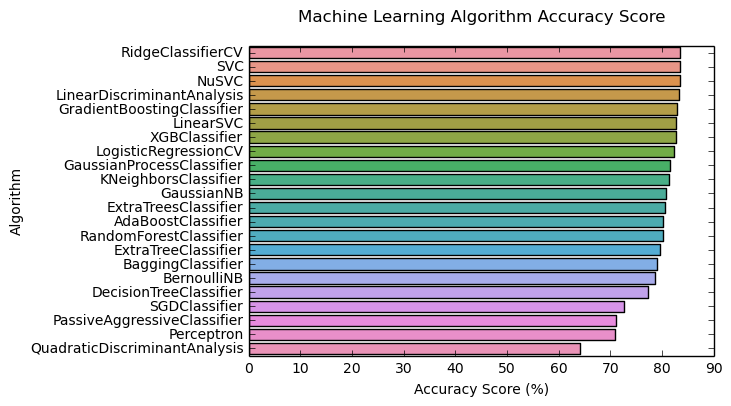

In [40]:
sns.barplot(MLA_compare["MLA Test Score Mean"],MLA_compare["MLA Name"])
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [41]:
MLA_compare['MLA Test Score Mean']=MLA_compare['MLA Test Score Mean'].astype(float)
MLA_compare['MLA Training Score Mean']=MLA_compare['MLA Training Score Mean'].astype(float)

In [42]:
MLA_compare.loc[MLA_compare['MLA Test Score Mean']>=82,"MLA Name"]

8              RidgeClassifierCV
14                           SVC
15                         NuSVC
19    LinearDiscriminantAnalysis
3     GradientBoostingClassifier
16                     LinearSVC
21                 XGBClassifier
6           LogisticRegressionCV
Name: MLA Name, dtype: object

In [27]:
"""
def mytree(df):
    
    #initialize table to store predictions
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master'] #survived titles

    for index, row in df.iterrows():

        #Question 1: Were you on the Titanic; majority died
        Model.loc[index, 'Predict'] = 0

        #Question 2: Are you female; majority survived
        if (df.loc[index, 'Sex'] == 'female'):
                  Model.loc[index, 'Predict'] = 1

        #Question 3A Female - Class and Question 4 Embarked gain minimum information

        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       
        if ((df.loc[index, 'Sex'] == 'female') & 
            (df.loc[index, 'Pclass'] == 3) & 
            (df.loc[index, 'Embarked'] == 'S')  &
            (df.loc[index, 'Fare'] > 8)

           ):
                  Model.loc[index, 'Predict'] = 0

        #Question 3B Male: Title; set anything greater than .5 to 1 for majority survived
        if ((df.loc[index, 'Sex'] == 'male') 
            ):
            Model.loc[index, 'Predict'] = 1
        
        
    return Model


#model data
Tree_Predict = mytree(train_raw)
print('Decision Tree Model Accuracy/Precision Score: {:.2f}%\n'.format(metrics.accuracy_score(train_raw['Survived'], Tree_Predict)*100))

print(metrics.classification_report(train_raw['Survived'], Tree_Predict))
"""

"\ndef mytree(df):\n    \n    #initialize table to store predictions\n    Model = pd.DataFrame(data = {'Predict':[]})\n    male_title = ['Master'] #survived titles\n\n    for index, row in df.iterrows():\n\n        #Question 1: Were you on the Titanic; majority died\n        Model.loc[index, 'Predict'] = 0\n\n        #Question 2: Are you female; majority survived\n        if (df.loc[index, 'Sex'] == 'female'):\n                  Model.loc[index, 'Predict'] = 1\n\n        #Question 3A Female - Class and Question 4 Embarked gain minimum information\n\n        #Question 5B Female - FareBin; set anything less than .5 in female node decision tree back to 0       \n        if ((df.loc[index, 'Sex'] == 'female') & \n            (df.loc[index, 'Pclass'] == 3) & \n            (df.loc[index, 'Embarked'] == 'S')  &\n            (df.loc[index, 'Fare'] > 8)\n\n           ):\n                  Model.loc[index, 'Predict'] = 0\n\n        #Question 3B Male: Title; set anything greater than .5 to 1 for 

In [36]:
"""
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree,x,y,cv=cv)
#dtree.fit(x, y)

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT train score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT test score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print('-'*10)

param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              #'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              #'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              #'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv)
tune_model.fit(x,y)

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT score mean: {:.2f}". format(tune_model.best_score_)) 
print('-'*10)
"""

('BEFORE DT Parameters: ', {'presort': False, 'splitter': 'best', 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 0, 'min_impurity_split': None, 'max_features': None, 'max_depth': None, 'class_weight': None})
BEFORE DT train score mean: 96.27
BEFORE DT test score mean: 77.77
----------
('AFTER DT Parameters: ', {'random_state': 0, 'criterion': 'gini', 'max_depth': 4})
AFTER DT score mean: 0.87
----------


In [40]:
"""
#base model
print('BEFORE DT RFE Training Shape Old: ', x.shape) 
print('BEFORE DT RFE Training Columns Old: ', x.columns.values)

print("BEFORE DT RFE Test score mean: {:.2f}". format(base_results['test_score'].mean()*100)) 
#print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
#print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv)
dtree_rfe.fit(x, y)

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = x.columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, train[X_rfe], y, cv  = cv)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', train[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

#print("AFTER DT RFE score mean: {:.2f}". format(np.mean(rfe_results))) 
print("AFTER DT RFE Train score mean: {:.2f}". format(rfe_results['train_score'].mean()*100))
print("AFTER DT RFE Test score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv)
rfe_tune_model.fit(train[X_rfe], y)

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned score mean: {:.2f}". format(rfe_tune_model.best_score_)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
#print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
#print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)
"""

('BEFORE DT RFE Training Shape Old: ', (891, 12))
('BEFORE DT RFE Training Columns Old: ', array(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'name_length',
       'family_size', 'is_along', 'Has_Cabin', 'title', 'FareBin',
       'AgeBin'], dtype=object))
BEFORE DT RFE Test score mean: 77.77
----------
('AFTER DT RFE Training Shape New: ', (891, 4))
('AFTER DT RFE Training Columns New: ', array(['Pclass', 'Sex', 'name_length', 'family_size'], dtype=object))
AFTER DT RFE Train score mean: 90.60
AFTER DT RFE Test score mean: 79.01
----------
('AFTER DT RFE Tuned Parameters: ', {'random_state': 0, 'criterion': 'entropy', 'max_depth': 4})
AFTER DT RFE Tuned score mean: 0.83
----------


In [ ]:
8              RidgeClassifierCV
14                           SVC
15                         NuSVC
19    LinearDiscriminantAnalysis
3     GradientBoostingClassifier
16                     LinearSVC
21                 XGBClassifier
6           LogisticRegressionCV

In [51]:
# only above 79!!!!!
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    #('ada', ensemble.AdaBoostClassifier()),
    #('bc', ensemble.BaggingClassifier()),
    #('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    #('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    #('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    #('bnb', naive_bayes.BernoulliNB()),
    #('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    #('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    #('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


In [52]:
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard,x,y,cv=cv)
vote_hard.fit(x, y)

#print("Hard Voting score mean: {:.2f}". format(np.mean(vote_hard_cv))) 
print("Hard Voting Train score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100))
print("Hard Voting Test score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft,x,y,cv=cv)
vote_soft.fit(x,y)

print("soft Voting Train score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100))
print("soft Voting Test score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print('-'*10)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Hard Voting Train score mean: 88.46
Hard Voting Test score mean: 83.05
----------


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

soft Voting Train score mean: 91.06
soft Voting Test score mean: 83.15
----------


In [ ]:
grid_n_estimator = [10, 50, 100, 300,400]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, 12, 16,None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]
grid_subsample=[0.7,0.8,0.9]
grid_colsample=[0.7,0.8,0.9]


grid_param = [
            #[{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            #'n_estimators': grid_n_estimator, #default=50
            #'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            #'random_state': grid_seed
            #}],
       
    
            #[{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            #'n_estimators': grid_n_estimator, #default=10
            #'max_samples': grid_ratio, #default=1.0
            #'random_state': grid_seed
            # }],

    
            #[{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            #'n_estimators': grid_n_estimator, #default=10
            #'criterion': grid_criterion, #default=”gini”
            #'max_depth': grid_max_depth, #default=None
            #'random_state': grid_seed
            # }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': grid_learn, #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': grid_n_estimator, #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            #[{    
            #GaussianProcessClassifier
            #'max_iter_predict': grid_n_estimator, #default: 100
            #'random_state': grid_seed
            #}],
        
    
            #[{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            #'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'], #default: lbfgs
            #liblinear, newton-cg, lbfgs and sag solvers, got saga
            #'random_state': grid_seed
            # }],
            
    
            #[{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            #'alpha': grid_ratio, #default: 1.0
            # }],
    
    
            #GaussianNB - 
            #[{}],
    
            #[{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            #'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            #'weights': ['uniform', 'distance'], #default = ‘uniform’
            #'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            #}],
            
    
            #[{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            #'C': [1,2,3,4,5], #default=1.0
            #'gamma': grid_ratio, #edfault: auto
            #'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            #'probability': [True],
            #'random_state': grid_seed
            # }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [2, 4, 6, 8, 10, 12, 16], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed,
            "nthread":-1,
            "colsample_bytree":grid_colsample,
            "subsample":grid_subsample
             }]   
        ]



import time
 #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip
    start_time=time.time()      
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv, scoring = 'roc_auc')
    best_search.fit(x,y)
    
    end_time=time.time()

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, end_time-start_time))
    clf[1].set_params(**best_param) 


print('-'*10)

In [ ]:
"""
x = train[X_rfe]
y = train[['Survived']]
"""

In [54]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard,x,y,cv=cv)
grid_hard.fit(x,y)

#print("Hard Voting score mean: {:.2f}". format(np.mean(vote_hard_cv))) 
print("Hard Voting Train score mean: {:.4f}". format(grid_hard_cv['train_score'].mean()*100))
print("Hard Voting Test score mean: {:.4f}". format(grid_hard_cv['test_score'].mean()*100))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft,x,y,cv=cv)
grid_soft.fit(x,y)

print("soft Voting Train score mean: {:.4f}". format(grid_soft_cv['train_score'].mean()*100))
print("soft Voting Test score mean: {:.4f}". format(grid_soft_cv['test_score'].mean()*100))
print('-'*10)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Hard Voting Train score mean: 87.4422
Hard Voting Test score mean: 83.1648
----------


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

soft Voting Train score mean: 87.6917
soft Voting Test score mean: 82.9401
----------


In [56]:
test['Survived'] = grid_hard.predict(test)
test_id=pd.read_csv("./data/test.csv")['PassengerId']
test = pd.concat([test_id,test],axis=1)
#submit file
submit = test[['PassengerId','Survived']]
submit.to_csv("./submit_20180806.csv", index=False)

#print('Validation Data Distribution: \n', data_val['Survived'].value_counts(normalize = True))
#submit.sample(10)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### reference

In [76]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [77]:
x = train_df.drop(['Survived'],axis=1)
y = train_df['Survived']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=2018)

def evaluate_model(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    a = accuracy_score(y_test,y_pred)
    cr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)
    print a
    print cr

In [78]:
from sklearn.ensemble import RandomForestClassifier
evaluate_model(RandomForestClassifier(class_weight='balanced'))

0.7947761194029851
             precision    recall  f1-score   support

          0       0.81      0.87      0.84       165
          1       0.76      0.68      0.72       103

avg / total       0.79      0.79      0.79       268



In [79]:
from sklearn.cross_validation import cross_val_score,KFold
cv = KFold(len(y),shuffle=True,n_folds=5,random_state=2018)
scores=cross_val_score(RandomForestClassifier(class_weight='balanced'),x,y,cv=cv)
print scores
print np.mean(scores)

[0.81005587 0.80337079 0.76966292 0.82022472 0.74719101]
0.790101060824807


In [120]:
import time
start_time=time.time()
xgb_params = {
    'silent':1,
    'eta':0.02,
    'max_depth':6,
    "gamma":0.9,
    "min_child_weight":2,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "nthread":-1,
    #'objective':"reg:linear",
    'objective':"binary:logistic",
    "eval_metric":"auc"  
}
dtrain=xgb.DMatrix(x,y)
cvresults = xgb.cv(xgb_params,dtrain,num_boost_round=500,nfold=5,shuffle=True,show_stdv=False,early_stopping_rounds=50)
print cvresults
end_time=time.time()
print("total time",end_time-start_time)

    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.864142      0.028116        0.880481       0.008027
1        0.865432      0.025335        0.884940       0.006108
2        0.864912      0.025422        0.886541       0.005650
3        0.868107      0.026033        0.888181       0.005456
4        0.867518      0.023874        0.888480       0.005522
5        0.868564      0.022661        0.888889       0.006243
6        0.871048      0.025343        0.890435       0.005434
7        0.867664      0.027485        0.894335       0.005704
8        0.867612      0.027873        0.894559       0.005462
9        0.867021      0.026212        0.895737       0.006857
10       0.866085      0.025721        0.896034       0.006262
11       0.866175      0.025411        0.895921       0.006152
12       0.867542      0.026194        0.895438       0.006204
13       0.868126      0.026415        0.895490       0.006336
14       0.868064      0.026070        0.895456       0

In [92]:
print( "\nTraining XGBoost ...")
#model = xgb.XGBRegressor( learning_rate =0.1, n_estimators=cvresults.shape[0], max_depth=6, 
#                                    subsample=0.8, objective= "reg:linear")
#model.fit(x,y)
#feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=cvresults.shape[0])


Training XGBoost ...


In [94]:
print( "\nPredicting with XGBoost ...")
dtest=xgb.DMatrix(test_df)
xgb_pred = model.predict(dtest)


Predicting with XGBoost ...


In [99]:
y_pred=xgb_pred
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0

In [100]:
# Generate Submission File 
Submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],
                            'Survived': y_pred })
Submission['Survived']=Submission.Survived.apply(lambda x: int(x))

In [106]:
Submission.to_csv("Submission.csv", index=False)

In [86]:
test_df.head()

,Pclass,Age,SibSp,Parch,Fare,name_length,family_size,is_along,Has_Cabin,Sex_0,Sex_1,title_0,title_1,title_2,title_3,title_4,Embarked_0,Embarked_1,Embarked_2
0,3,2,0,0,0,16,1,False,1,0,1,0,0,1,0,0,0,1,0
1,3,2,1,0,0,32,2,False,1,1,0,0,0,0,1,0,0,0,1
2,2,3,0,0,1,25,1,True,1,0,1,0,0,1,0,0,0,1,0
3,3,1,0,0,1,16,1,False,1,0,1,0,0,1,0,0,0,0,1
4,3,1,1,1,1,44,3,True,1,1,0,0,0,0,1,0,0,0,1


In [90]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
